In [585]:
!pip install -r requirements.txt


[notice] A new release of pip available: 22.3 -> 24.1.2
[notice] To update, run: pip3 install --upgrade pip
Reshimming asdf python...


In [1063]:
import crop_sim
import importlib
importlib.reload(crop_sim)

<module 'crop_sim' from '/Users/theron/code/crop-models/crop_sim.py'>

In [1064]:
zip_codes = crop_sim.load_zip("33483")
print(zip_codes)

     ZIP  latitude  longitude
0  33483   26.4546   -80.0656


In [1065]:
# crop_sim.generate_near()

In [1066]:
loca_tasmin, loca_tasmax = crop_sim.load_temperature_data(zip_codes)

In [1067]:
ecocrop_df = crop_sim.load_ecocrop()

In [1068]:


# Select your crop of interest (replace 'Maize' with your desired crop)
crop_name = 'Allium cepa' #onion
# crop_name= "Lycopersicon esculentum" # Tomatoes
# crop_name = "Brassica juncea" # Mustard greens
# crop_name = "Vigna unguiculata"
# crop_name = "Ipomoea batatas" # sweet potato
# crop_name = "Solanum tuberosum" # Potato
bolting = False
frost_tolerance = 0

tmin, tmax, topt_min, topt_max, gmin, gmax = crop_sim.load_crop_variables(ecocrop_df, crop_name)


In [1069]:
zip_codes = crop_sim.add_loca_index(zip_codes, loca_tasmin, loca_tasmax)

In [1070]:
print(zip_codes['loca_index'].values)

[(23, 30)]


In [1071]:
lat, lon = zip_codes['loca_index'].values[0]

In [1072]:
loca_tasmin_smoothed, loca_tasmax_smoothed = crop_sim.smooth_tas(loca_tasmin, loca_tasmax)

In [1073]:
daily_suitability = crop_sim.suitability(bolting, loca_tasmin_smoothed, loca_tasmax_smoothed, tmin, tmax, topt_min, topt_max, frost_tolerance)

In [1074]:
# print(daily_suitability.isel(lat=lat, lon=lon))

In [1075]:
growing_season_suitability = crop_sim.calculate_season_suitability(gmin, gmax, daily_suitability)
optimal_planting_ranges = crop_sim.calculate_optimal_planting_ranges(growing_season_suitability, lat, lon)


In [1076]:
view_window = 105
print(optimal_planting_ranges)

{85: [[Timestamp('2022-11-22 12:00:00'), Timestamp('2023-01-15 12:00:00')]], 95: [[Timestamp('2022-11-22 12:00:00'), Timestamp('2023-01-05 12:00:00')]], 105: [[Timestamp('2022-11-22 12:00:00'), Timestamp('2022-12-26 12:00:00')]], 115: [[Timestamp('2022-11-22 12:00:00'), Timestamp('2022-12-16 12:00:00')]], 125: [[Timestamp('2022-11-22 12:00:00'), Timestamp('2022-12-06 12:00:00')]], 135: [[Timestamp('2022-11-22 12:00:00'), Timestamp('2022-11-26 12:00:00')]], 145: [], 155: [], 165: [], 175: []}


In [1077]:
matplotlib.pyplot.close()

In [1078]:
print(crop_sim.merge_overlapping_monthday_ranges(optimal_planting_ranges[view_window]))

[(11, 22, 12, 26)]


In [1079]:
%matplotlib widget

In [1080]:
import matplotlib

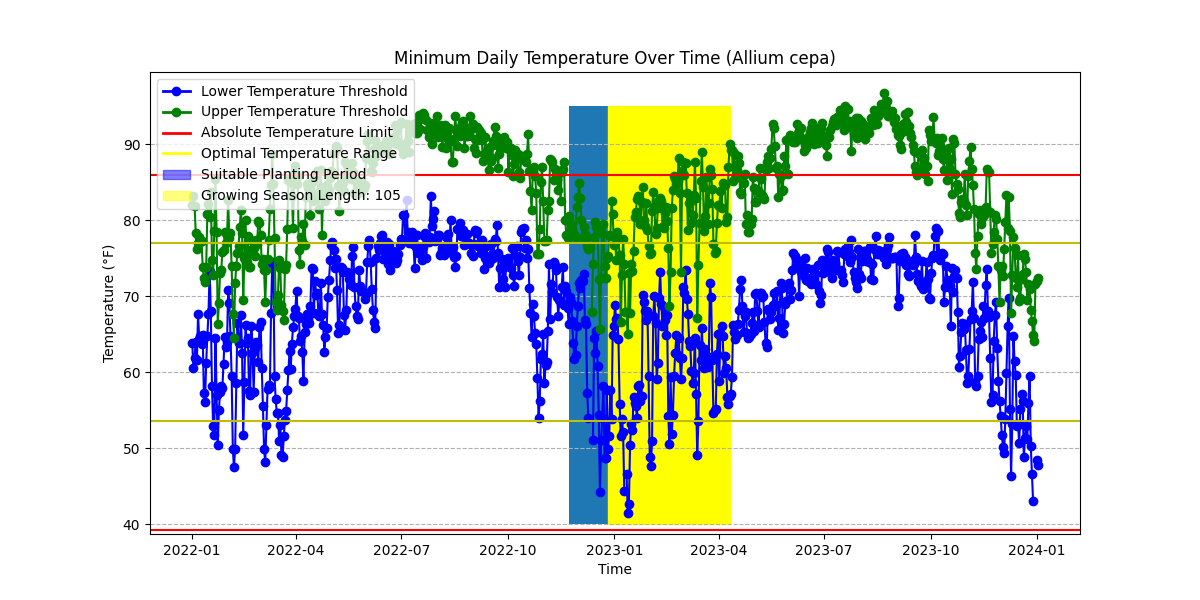

In [1081]:

crop_sim.plot_planting(loca_tasmin_smoothed, loca_tasmax_smoothed, tmin, tmax, topt_min, topt_max, view_window, optimal_planting_ranges, lat, lon, crop_name)


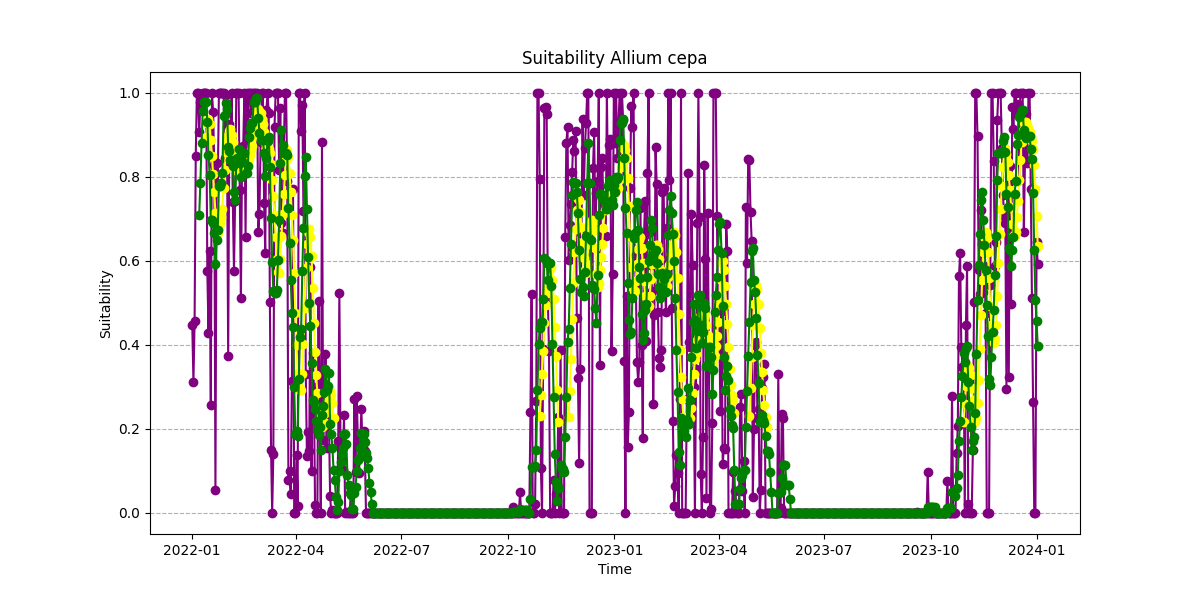

In [1082]:
crop_sim.plot_suitability(view_window, growing_season_suitability, daily_suitability, lat, lon, crop_name)